# Normal Distribution

This notebook serves as an introduction to univariate and multivariate normal 
(Gaussian) distributions. Understanding these distributions, particularly the 
role of the mean and standard deviation/covariance matrix, is fundamental for 
grasping how certain optimization algorithms, like the Covariance Matrix 
Adaptation Evolution Strategy (CMA-ES), explore the search space.

### Recommended Reading:
1. [Are You Normal? Hint: No.](https://allendowney.github.io/ProbablyOverthinkingIt/gaussian.html)
2. 3Blue1Brown [But what is the Central Limit Theorem?](https://www.youtube.com/watch?v=zeJD6dqJ5lo)

## 1. Setup and Imports
 
First, let's import the necessary libraries and configure the plotting settings.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import scipy.stats as stats

sns.set_style('darkgrid')
np.random.seed(42)

## 2. The Univariate Normal (Gaussian) Distribution

The simplest case is the one-dimensional, or [univariate, normal distribution](https://en.wikipedia.org/wiki/Normal_distribution). It's perhaps the most common probability distribution.

### Definition
It's characterized by two parameters:
1.  **Mean ($\mu$)**: This represents the center or expected value of the distribution. It dictates where the peak of the bell curve is located.
2.  **Variance ($\sigma^2$)**: This measures the spread or dispersion of the distribution. A higher variance means the distribution is wider; a lower variance means it's narrower.

The **standard deviation ($\sigma$)** is simply the square root of the variance ($\sigma = \sqrt{\sigma^2}$). It provides a measure of the typical distance of data points from the mean.

We denote this distribution as $\mathcal{N}(\mu, \sigma)$.

### Probability Density Function (PDF)

The shape of the bell curve is defined by the [Probability Density Function (PDF)](https://en.wikipedia.org/wiki/Probability_density_function) (pl. gęstość prawdopodobieństwa). For a given value $x$, the probability density is calculated as:

$$p(x \mid \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp{ \left( -\frac{(x - \mu)^2}{2\sigma^2}\right)}$$

The term $\frac{1}{\sqrt{2\pi\sigma^2}}$ is a normalization constant that ensures the total area under the curve integrates to 1. The `exp(...)` term creates the characteristic bell shape, centered at $\mu$ and scaled by $\sigma$.

### Exercise 1: Implement the Univariate PDF

Manually implement the PDF function for the univariate normal distribution. Your function should take `x` (a NumPy array, multiple values), `mean`, and `sigma` (standard deviation) as input.

Compare the output of your function for a few test cases against the `scipy.stats.norm.pdf`.

In [4]:
def univariate_normal_pdf(x: np.ndarray, mean: float, std_dev: float) -> np.ndarray:
    return 1 / (np.sqrt(2 * np.pi * std_dev ** 2)) * np.exp(-(np.square(x - mean)) / (2 * std_dev ** 2))

In [5]:
test_x = np.array([-1, 0, 1, 2])
test_mean = 0
test_sigma = 1

pdf_output = univariate_normal_pdf(test_x, mean=test_mean, std_dev=test_sigma)
scipy_pdf_output = stats.norm.pdf(test_x, loc=test_mean, scale=test_sigma)

print("Test x values:", test_x)
print("Your PDF output:    ", pdf_output)
print("Scipy PDF output:   ", scipy_pdf_output)
# Check if outputs are close (allowing for floating point differences)
print("\nAre outputs close (Your vs Scipy)?", np.allclose(pdf_output, scipy_pdf_output))

Test x values: [-1  0  1  2]
Your PDF output:     [0.24197072 0.39894228 0.24197072 0.05399097]
Scipy PDF output:    [0.24197072 0.39894228 0.24197072 0.05399097]

Are outputs close (Your vs Scipy)? True


Observe how changing $\mu$ shifts the curve left or right, and changing $\sigma$ changes its width and height (while maintaining the total area of 1).

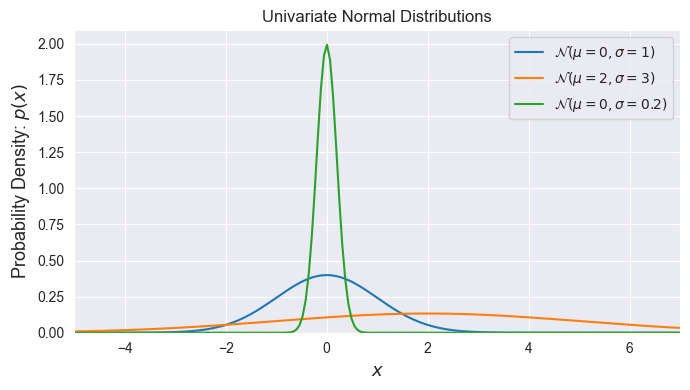

In [11]:
x_vals = np.linspace(-5, 7, num=200)
fig = plt.figure(figsize=(7, 4))

plt.plot(x_vals, univariate_normal_pdf(x_vals, mean=0, std_dev=1), 
         label="$\\mathcal{N}(\\mu=0, \\sigma=1)$")
plt.plot(x_vals, univariate_normal_pdf(x_vals, mean=2, std_dev=3), 
         label="$\\mathcal{N}(\\mu=2, \\sigma=3)$")
plt.plot(x_vals, univariate_normal_pdf(x_vals, mean=0, std_dev=0.2), 
         label="$\\mathcal{N}(\\mu=0, \\sigma=0.2)$")

plt.xlabel('$x$', fontsize=13)
plt.ylabel('Probability Density: $p(x)$', fontsize=13)
plt.title('Univariate Normal Distributions')
plt.ylim(bottom=0)
plt.xlim(x_vals.min(), x_vals.max())
plt.legend(loc='best')
fig.tight_layout() # Adjust layout
plt.show()

In a graph of a PDF, `x` is the specific outcome or value along the bottom, and `y` is its associated 'density,' indicating how concentrated the probability is right at that point `x`.

### Exercise 2: The 3-Sigma Rule

Motivation: How to interpret $\sigma$?

The standard deviation ($\sigma$) gives us a standardized way to understand the spread. The [68-95-99.7 rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule), or "3-sigma rule", states that for a normal distribution:
- Approximately **68%** of the data falls within **1** standard deviation of the mean ($\mu \pm 1\sigma$).
- Approximately **95%** of the data falls within **2** standard deviations of the mean ($\mu \pm 2\sigma$).
- Approximately **99.7%** of the data falls within **3** standard deviations of the mean ($\mu \pm 3\sigma$).

We will verify these rules empirically by sampling.

**Task:**

- **Generate Samples:** Draw a large number of samples (e.g., N = 10,000) from a standard normal distribution $\mathcal{N}(0, 1)$ using `np.random.normal`.
- **Count Samples in Intervals:** For each interval ($\mu \pm 1\sigma$, $\mu \pm 2\sigma$, $\mu \pm 3\sigma$), count how many of your generated samples fall within that range.
- **Calculate Proportions:** Calculate the proportion (or percentage) of samples that fall into each interval (count / total number of samples).
- **Compare:** Print your calculated proportions and compare them to the theoretical values (68%, 95%, 99.7%).

**Interpretation Questions:**

How close are your empirical results to the theoretical percentages?
Why might your results not match the theoretical values exactly?
(Optional) Try running the code again with a much smaller N (e.g., 100) and a much larger N (e.g., 1,000,000). How does the number of samples affect the accuracy of your empirical verification?

In [80]:
def check_sigmas(no_samples=10_000):
    samples = np.random.normal(size=no_samples)
    one_sigma = (np.abs(samples) < 1).sum()
    two_sigma = (np.abs(samples) < 2).sum()
    three_sigma = (np.abs(samples) < 3).sum()
    
    print("----------------------------------")
    print(f"For {no_samples} samples we got:")
    print(f"{one_sigma / no_samples * 100:.2f} % falls within 1 sigma. Difference with theoretical value: {one_sigma / no_samples * 100 - 68:.2f}")
    print(f"{two_sigma / no_samples * 100:.2f} % falls within 2 sigma. Difference with theoretical value: {two_sigma / no_samples * 100 - 95:.2f}")
    print(f"{three_sigma / no_samples * 100:.2f} % falls within 3 sigma. Difference with theoretical value: {three_sigma / no_samples * 100 - 99.7:.2f}")

In [82]:
check_sigmas(100)
check_sigmas(10_000)
check_sigmas(1_000_000)

----------------------------------
For 100 samples we got:
71.00 % falls within 1 sigma. Difference with theoretical value: 3.00
96.00 % falls within 2 sigma. Difference with theoretical value: 1.00
100.00 % falls within 3 sigma. Difference with theoretical value: 0.30
----------------------------------
For 10000 samples we got:
67.71 % falls within 1 sigma. Difference with theoretical value: -0.29
95.86 % falls within 2 sigma. Difference with theoretical value: 0.86
99.80 % falls within 3 sigma. Difference with theoretical value: 0.10
----------------------------------
For 1000000 samples we got:
68.31 % falls within 1 sigma. Difference with theoretical value: 0.31
95.49 % falls within 2 sigma. Difference with theoretical value: 0.49
99.74 % falls within 3 sigma. Difference with theoretical value: 0.04


How close are your empirical results to the theoretical percentages?
Why might your results not match the theoretical values exactly?
(Optional) Try running the code again with a much smaller N (e.g., 100) and a much larger N (e.g., 1,000,000). How does the number of samples affect the accuracy of your empirical verification?

My empirical results are close to theoretical percentages \
We did not match the theoretical values exactly because we are choosing samples randomly. There is always a chance to roll dice differently. We would need infinite number of samples to match the theoretical values exactly (not possible) \
The more samples the higher chance that we will get closer to the theoretical values (but it might not be the case as shown in my example)
 

## 3. The Central Limit Theorem (CLT)

We've seen the definition and shape of the normal distribution. But *why* is
it so important and common in nature and statistics? The Central Limit Theorem
provides a powerful answer.

### 3.1 Theory: Why is the Normal Distribution Everywhere?

The [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem)
is a cornerstone of probability theory. In simple terms, it states that if you
take the **sum or average** of many independent and identically distributed (i.i.d.)
random variables, the distribution of that sum or average will tend towards a
**normal distribution**, regardless of the original distribution of the individual
variables.

Think about it:
- Many real-world measurements (like height, weight, errors in experiments) can
  be thought of as the result of *many small, independent factors* added together.
- In statistics, we often calculate the *average* (mean) of a sample to estimate
  a population parameter. The CLT tells us that the distribution of these *sample means*
  will be approximately normal, even if the underlying population data isn't,
  provided our sample size is large enough.

This allows us to use the properties of the normal distribution for statistical
inference (like constructing confidence intervals or performing hypothesis tests)
even when we don't know the original data's distribution.

We can demonstrate this empirically using simulation. Let's simulate a simple
process: tossing a coin many times and calculating the proportion of tails (which
is the *average* result, if we code Tails=1, Heads=0). We'll repeat this experiment
many times (trials) and look at the distribution of these calculated proportions.

### 3.2 Simulating Sample Means (Coin Tosses)

We'll define a function to run a coin-tossing experiment multiple times. Each
experiment (trial) involves tossing a coin a fixed number of times and calculating
the proportion of tails. According to the CLT, the distribution of these proportions
should look increasingly normal as the number of tosses per trial increases.

In [109]:
def run_experiment(number_of_trials: int, number_of_tosses: int, probabilities: list[float] = (0.5, 0.5)) -> np.ndarray:
    """
    Simulates a coin-tossing experiment across multiple trials and returns the estimated
    probability (proportion) of getting tails in each trial.

    Parameters:
    ----------
    number_of_trials : int
        The number of independent trials to run. Each trial consists of multiple coin tosses.
    number_of_tosses : int
        The number of coin tosses to perform in each trial.
    probabilities : list[float], optional
        A list representing the probabilities for the two outcomes [HEADS (0), TAILS (1)].
        By default, this is set to [0.5, 0.5], simulating a fair coin.

    Returns:
    -------
    np.ndarray
        A NumPy array of floats, where each element is the proportion of tails (1) observed in
        a single trial. The length of the array is equal to `number_of_trials`.

    Description:
    ------------
    For each trial, the function simulates `number_of_tosses` coin flips using the specified
    probabilities (0 for Heads, 1 for Tails). It then computes the mean of these flips,
    which represents the proportion of tails for that trial. The results from all trials
    are collected and returned.
    """
    
    if sum(probabilities) != 1:
        raise "Probabilities must sum to 1!"
    
    arr = np.zeros(number_of_trials)
    
    for i in range(number_of_trials):
        counter = (np.random.random(number_of_tosses) < probabilities[1]).sum()
        arr[i] = counter / number_of_tosses
        
    return arr

In [100]:
def plot_clt_histogram(proportions: np.ndarray, number_of_tosses: int) -> None:
    plt.figure(figsize=(8, 5))
    sns.histplot(proportions, kde=True, stat='density')
    plt.title(f"Distribution of Sample Mean (Proportion of Tails)\n"
              f"{len(proportions)} Trials, {number_of_tosses} Tosses/Trial")
    plt.xlabel("Proportion of Tails in a Trial (Sample Mean)")
    plt.ylabel("Density")
    plt.show()

### 3.3 Exercise 3: Observing the CLT in Action

Run the experiment for different `number_of_trials` and `number_of_tosses`. Visualize the results. Use a biased coin, for example, `probabilities = [0.8, 0.2]`.

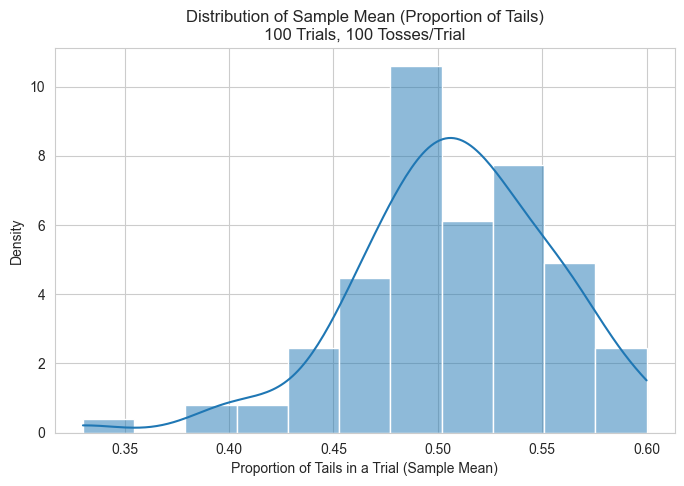

In [116]:
# fair coin
number_of_trials = 100
number_of_tosses = 100
prob = (0.5, 0.5)

plot_clt_histogram(run_experiment(number_of_trials, number_of_tosses, prob), number_of_tosses)


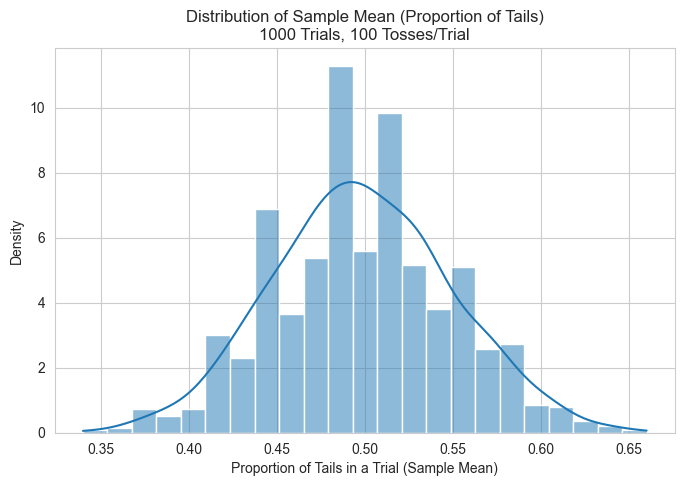

In [107]:
# fair coin
number_of_trials = 1000
number_of_tosses = 100
prob = (0.5, 0.5)

plot_clt_histogram(run_experiment(number_of_trials, number_of_tosses, prob), number_of_tosses)


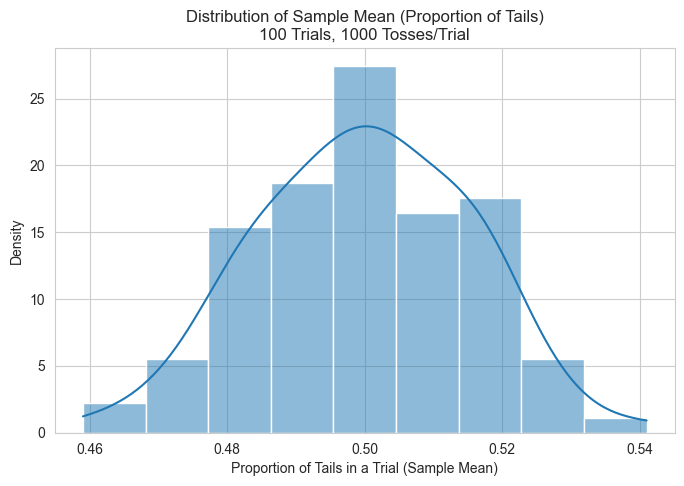

In [108]:
# fair coin
number_of_trials = 100
number_of_tosses = 1000
prob = (0.5, 0.5)

plot_clt_histogram(run_experiment(number_of_trials, number_of_tosses, prob), number_of_tosses)


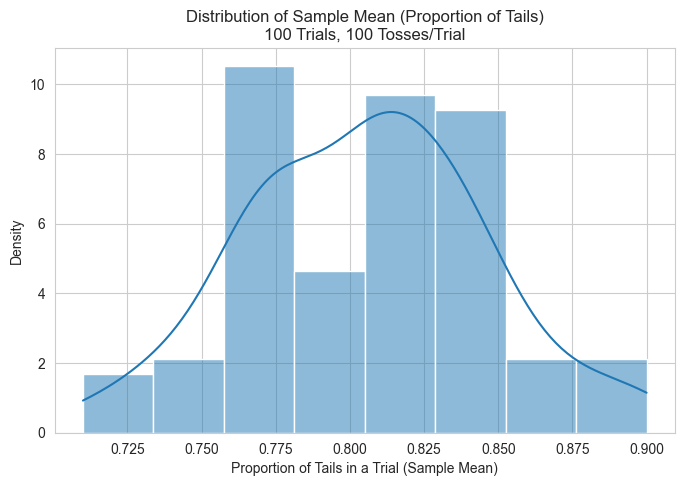

In [112]:
# unfair coin
number_of_trials = 100
number_of_tosses = 100
prob = (0.2, 0.8)

plot_clt_histogram(run_experiment(number_of_trials, number_of_tosses, prob), number_of_tosses)


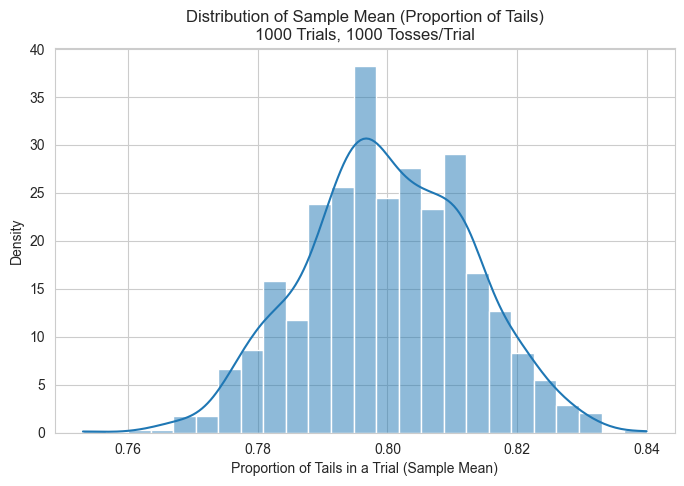

In [113]:
# unfair coin
number_of_trials = 1000
number_of_tosses = 1000
prob = (0.2, 0.8)

plot_clt_histogram(run_experiment(number_of_trials, number_of_tosses, prob), number_of_tosses)

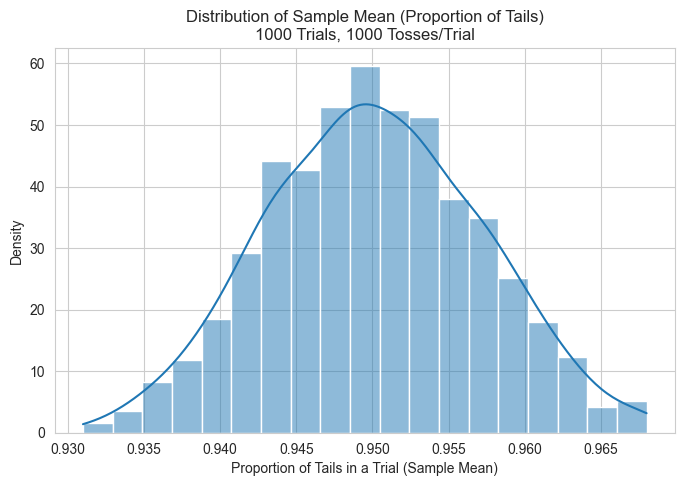

In [114]:
# unfair coin
number_of_trials = 1000
number_of_tosses = 1000
prob = (0.05, 0.95)

plot_clt_histogram(run_experiment(number_of_trials, number_of_tosses, prob), number_of_tosses)

The greater number of tosses and trials the more distibution looks like normal distribution

## 4. The Multivariate Normal Distribution

Now, let's extend this concept to multiple dimensions. The [multivariate normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) describes the distribution of a vector of random variables, where each variable is normally distributed and potentially correlated with the others.

### Definition
For a $d$-dimensional random vector $\mathbf{x} = [x_1, x_2, ..., x_d]^T$, the multivariate normal distribution is defined by:
1.  **Mean Vector ($\mathbf{\mu}$)**: A $d$-dimensional vector representing the expected value for each dimension. $\mathbf{\mu} = [\mu_1, \mu_2, ..., \mu_d]^T$.
2.  **Covariance Matrix ($\Sigma$)**: A $d \times d$ symmetric and positive semi-definite matrix.
    * The diagonal elements ($\Sigma_{ii}$) represent the variance of the $i$-th variable ($Var(x_i) = \sigma_i^2$).
    * The off-diagonal elements ($\Sigma_{ij}$) represent the covariance between the $i$-th and $j$-th variables ($Cov(x_i, x_j)$). Covariance indicates how two variables change together.
        * $Cov(x_i, x_j) > 0$: $x_i$ tends to increase when $x_j$ increases (positive correlation).
        * $Cov(x_i, x_j) < 0$: $x_i$ tends to decrease when $x_j$ increases (negative correlation).
        * $Cov(x_i, x_j) = 0$: $x_i$ and $x_j$ are uncorrelated (if jointly normal, this also means they are independent).

We denote this distribution as $\mathcal{N}(\mathbf{\mu}, \Sigma)$.

### Probability Density Function (PDF)

The PDF for a $d$-dimensional vector $\mathbf{x}$ is given by:

$$
p(\mathbf{x} \mid \mathbf{\mu}, \Sigma) = \frac{1}{\sqrt{(2\pi)^d |\Sigma|}} \exp{ \left( -\frac{1}{2}(\mathbf{x} - \mathbf{\mu})^T \Sigma^{-1} (\mathbf{x} - \mathbf{\mu}) \right)}
$$

Where:
- $|\Sigma|$ is the determinant of the covariance matrix.
- $\Sigma^{-1}$ is the inverse of the covariance matrix.
- $(\mathbf{x} - \mathbf{\mu})^T \Sigma^{-1} (\mathbf{x} - \mathbf{\mu})$ is a quadratic form known as the Mahalanobis distance squared, which measures the distance from $\mathbf{x}$ to the mean $\mathbf{\mu}$, accounting for the covariance structure.

Let's define a function

In [120]:
def multivariate_normal_pdf(x: np.ndarray, mean: np.ndarray, covariance: np.ndarray) -> np.ndarray:
    """
    Computes the multivariate normal PDF for a batch of input vectors `x`.

    Parameters:
        x : np.ndarray Shape (N, D), where N is the number of samples and D is the dimensionality.
        mean : np.ndarray Shape (D,), the mean vector.
        covariance : np.ndarray Shape (D, D), the covariance matrix.

    Returns:
        np.ndarray: Shape (N,), the PDF values for each input sample.
    """
    d = mean.shape[0]
    diff = x - mean
    cov_inv = np.linalg.inv(covariance)
    exponent = -0.5 * np.sum(diff @ cov_inv * diff, axis=1)
    norm_const = 1 / np.sqrt((2 * np.pi) ** d * np.linalg.det(covariance))
    return norm_const * np.exp(exponent)
    # return 1 / np.sqrt(((2 * np.pi) ** d) * np.linalg.det(covariance)) * np.exp(- 0.5 * (x - mean).T @ np.linalg.inv(covariance) @ (x - mean))

### Visualization (2D Case)

Visualizing beyond 2 or 3 dimensions is difficult. Let's focus on the bivariate ($d=2$) case to understand the impact of the covariance matrix. We'll plot the probability density as contours.


In [121]:
def generate_surface(mean: np.ndarray, covariance: np.ndarray, num_points: int = 50, range_std_dev: int = 3):
    """
    Generates a surface grid of multivariate normal PDF values over a 2D mesh.

    Parameters:
        mean (np.ndarray): Shape (2,) or (2,1), the mean vector.
        covariance (np.ndarray): Shape (2,2), the covariance matrix.
        num_points (int): Number of points along each axis.
        range_std_dev (int): Range of standard deviations to cover.

    Returns:
        x1, x2 (np.ndarray): Meshgrid arrays.
        pdf (np.ndarray): Computed PDF values at each grid point.
        bounds (tuple): (x1_min, x1_max, x2_min, x2_max)
    """
    mean = mean.flatten()
    std_devs = np.sqrt(np.diag(covariance))

    x1_min = mean[0] - range_std_dev * std_devs[0]
    x1_max = mean[0] + range_std_dev * std_devs[0]
    x2_min = mean[1] - range_std_dev * std_devs[1]
    x2_max = mean[1] + range_std_dev * std_devs[1]

    x1s = np.linspace(x1_min, x1_max, num=num_points)
    x2s = np.linspace(x2_min, x2_max, num=num_points)
    x1, x2 = np.meshgrid(x1s, x2s)

    points = np.column_stack([x1.ravel(), x2.ravel()])
    pdf_values = multivariate_normal_pdf(points, mean, covariance)
    pdf = pdf_values.reshape(num_points, num_points)

    return x1, x2, pdf, (x1_min, x1_max, x2_min, x2_max)

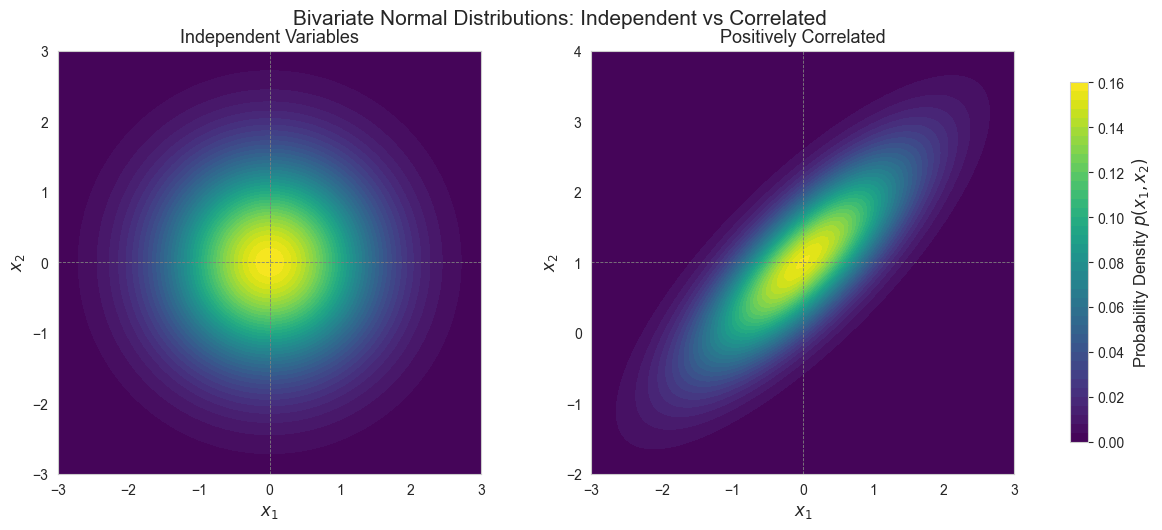

In [122]:
# Define distributions
mean1 = np.array([0., 0.])
cov1 = np.array([[1., 0.], 
                 [0., 1.]])

mean2 = np.array([0., 1.])
cov2 = np.array([[1.0, 0.8], 
                 [0.8, 1.0]])

num_points = 100
range_std = 3
x1_1, x2_1, pdf1, lim1 = generate_surface(mean1, cov1, num_points, range_std)
x1_2, x2_2, pdf2, lim2 = generate_surface(mean2, cov2, num_points, range_std)

# Plot setup
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
levels = 40
cmap = cm.viridis

# Plot: Independent
cf1 = axes[0].contourf(x1_1, x2_1, pdf1, levels=levels, cmap=cmap)
axes[0].set_title("Independent Variables", fontsize=13)
axes[0].set_xlabel(r'$x_1$', fontsize=12)
axes[0].set_ylabel(r'$x_2$', fontsize=12)
axes[0].set_aspect('equal')
axes[0].axhline(mean1[1], color='gray', ls='--', lw=0.6)
axes[0].axvline(mean1[0], color='gray', ls='--', lw=0.6)

# Plot: Correlated
cf2 = axes[1].contourf(x1_2, x2_2, pdf2, levels=levels, cmap=cmap)
axes[1].set_title("Positively Correlated", fontsize=13)
axes[1].set_xlabel(r'$x_1$', fontsize=12)
axes[1].set_ylabel(r'$x_2$', fontsize=12)
axes[1].set_aspect('equal')
axes[1].axhline(mean2[1], color='gray', ls='--', lw=0.6)
axes[1].axvline(mean2[0], color='gray', ls='--', lw=0.6)

cbar = fig.colorbar(cf1, ax=axes, orientation='vertical', shrink=0.85, pad=0.05)
cbar.set_label(r'Probability Density $p(x_1, x_2)$', fontsize=12)
fig.suptitle('Bivariate Normal Distributions: Independent vs Correlated', fontsize=15, y=1.03)
plt.show()

**Observations:**
- **Independent Case:** The contours are circular (or elliptical aligned with axes if variances differ). The distribution spreads equally along the axes defined by the standard deviations ($\sigma_1 = \sqrt{1}=1, \sigma_2 = \sqrt{1}=1$).
- **Correlated Case:** The contours are elliptical and tilted. The positive covariance (0.8) means that higher values of $x_1$ are associated with higher values of $x_2$. The main axis of the ellipse reflects this correlation direction. The mean vector shifts the center of the distribution to $(0, 1)$.

### Exercise 4: Visualizing Covariance Matrices

Explore how different covariance matrices affect the shape and orientation of a 2D normal distribution centered at $\mathbf{\mu} = [0, 0]^T$.

**Task:** For each of the covariance matrices below, use the `generate_surface` function to plot the corresponding 2D normal distribution. Describe your observations for each case – how does the shape/orientation relate to the values in the covariance matrix?

1.  `cov_a = np.array([[2.0, 0.0], [0.0, 0.5]])`
2.  `cov_b = np.array([[1.0, -0.7], [-0.7, 1.0]])`
3.  `cov_c = np.array([[1.5, 0.9], [0.9, 1.5]])`


In [153]:
mean = np.array([0., 0.])

cov1 = np.array([[2.0, 0.0], 
                 [0.0, 0.5]])

cov2 = np.array([[1.0, -0.7], 
                 [-0.7, 1.0]])

cov3 = np.array([[1.5, 0.9], 
                 [0.9, 1.5]])

num_points = 100
range_std = 3

In [154]:
x1_1, x2_1, pdf1, _ = generate_surface(mean, cov1, num_points, range_std)
x1_2, x2_2, pdf2, _ = generate_surface(mean, cov2, num_points, range_std)
x1_3, x2_3, pdf3, _ = generate_surface(mean, cov3, num_points, range_std)

In [141]:
def plot_surfaces(x1, x2, pdf):
    fig, axe = plt.subplots(1, 1, figsize=(12, 5), constrained_layout=True)
    levels = 40
    cmap = cm.viridis
    
    cf1 = axe.contourf(x1, x2, pdf, levels=levels, cmap=cmap)
    axe.set_xlabel(r'$x_1$', fontsize=12)
    axe.set_ylabel(r'$x_2$', fontsize=12)
    axe.set_aspect('equal')
    axe.axhline(mean1[1], color='gray', ls='--', lw=0.6)
    axe.axvline(mean1[0], color='gray', ls='--', lw=0.6)
    
    cbar = fig.colorbar(cf1, ax=axe, orientation='vertical', shrink=0.85, pad=0.05)
    cbar.set_label(r'Probability Density $p(x_1, x_2)$', fontsize=12)
    plt.show()

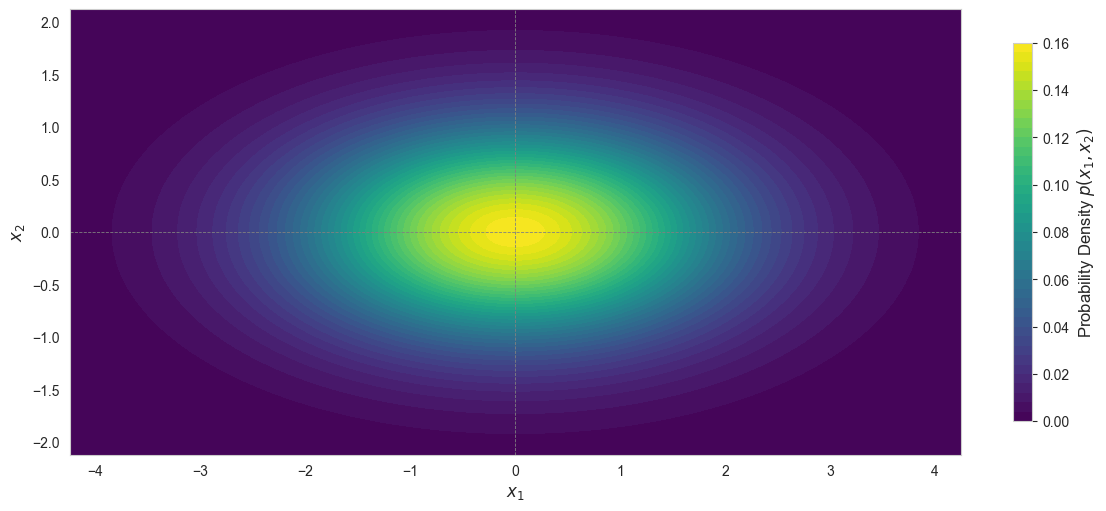

In [142]:
plot_surfaces(x1_1, x2_1, pdf1)

The variance along x1 is greater than along x2, therefore x1 is more spread out. The variables are uncorrelated, so the contours are not tilted.

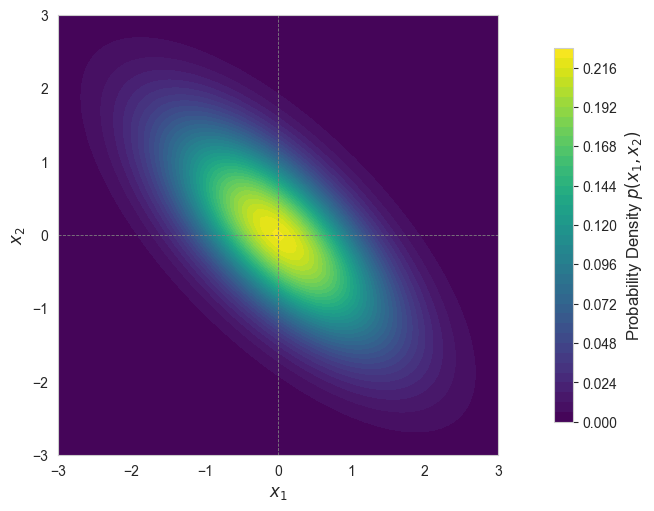

In [143]:
plot_surfaces(x1_2, x2_2, pdf2)

The variances along x1 and x2 are equal. The covariance is negative, indicating that as x1 increases, x2 tends to decrease. Because the variables are negatively correlated, the contours are tilted and elongated along the direction from top left to bottom right.

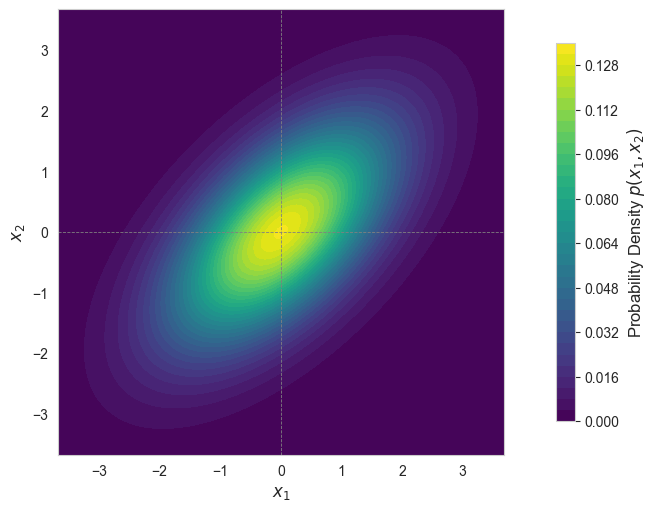

In [144]:
plot_surfaces(x1_3, x2_3, pdf3)

The variances along x1 and x2 are equal and relatively large, indicating moderate spread in both directions. The positive covariance means that x1 and x2 tend to increase together. As a result, the contours are tilted and elongated along the direction from bottom left to top right.

### Exercise 5*: Eigen-decomposition and Geometric Interpretation

**Goal:** To visually confirm how the mathematical components of the covariance matrix ($\Sigma$) determine the geometric shape of the 2D normal distribution.

**Core Idea:**
The **eigenvectors** of $\Sigma$ point along the principal axes (major and minor axes) of the probability density ellipse, defining its **orientation**. The **square root of the eigenvalues** ($\sqrt{\lambda_i}$) correspond to the **standard deviation** of the distribution along those principal axes, defining the **spread** or scale along each axis.

**Task:**

1.  **Choose Parameters:** Select a 2D mean vector $\mu$ (e.g., `[0, 0]`) and a *non-diagonal* covariance matrix $\Sigma$ from the previous exercise (e.g., `cov_b` or `cov_c`).
2.  **Calculate Decomposition:** Use `np.linalg.eig` to compute the eigenvalues ($\lambda_i$) and eigenvectors ($V$) of your chosen $\Sigma$.
3.  **Plot Contours:** Use the `generate_surface` function and `plt.contourf` to plot the probability density contours for your chosen $\mu$ and $\Sigma$.
4.  **Plot Eigenvector Axes:** On the *same plot*:
    * For each eigenvector, draw a line starting at the mean $\mu$.
    * The line should point in the eigenvector's direction.
    * The length of the line should represent the spread along that axis. A good choice is to make the total length $2 \times \text{scale\_factor} \times \sqrt{\lambda_i}$ (e.g., `scale_factor=2` for $\pm 2$ standard deviations), centered at the mean. Use `plt.plot` or `ax.quiver`.
5.  **Interpret:** Observe your plot. Do the lines you drew (representing the scaled eigenvectors) align perfectly with the ellipse's axes? Does the length of each line correspond to the spread (width/height) of the ellipse along that direction?

*(Remember to use `ax.set_aspect('equal')` for accurate geometric representation!)*

In [156]:
mean = np.array([0., 0.])

# cov2 = np.array([[1.0, -0.7], 
#                  [-0.7, 1.0]])

cov3 = np.array([[1.5, 0.9], 
                 [0.9, 1.5]])

cov = cov3

num_points = 100
range_std = 3

In [157]:
eigenvalues, eigenvectors = np.linalg.eig(cov)

In [158]:
x1, x2, pdf, _ = generate_surface(mean, cov, num_points, range_std)

In [168]:
def plot_surfaces_with_eigenvectors(x1, x2, pdf, mean, cov):
    fig, ax = plt.subplots(1, 1, figsize=(12, 5), constrained_layout=True)
    levels = 40
    cmap = cm.viridis
    
    cf1 = ax.contourf(x1, x2, pdf, levels=levels, cmap=cmap)
    ax.set_xlabel(r'$x_1$', fontsize=12)
    ax.set_ylabel(r'$x_2$', fontsize=12)
    ax.set_aspect('equal')
    ax.axhline(mean1[1], color='gray', ls='--', lw=0.6)
    ax.axvline(mean1[0], color='gray', ls='--', lw=0.6)
    
    eigvals, eigvecs = np.linalg.eig(cov)
    scale_factor = 2
    
    colors = ["red", "orange"]

    for i in range(2):  
        vec = eigvecs[:, i]
        length = scale_factor * np.sqrt(eigvals[i])
        start = mean
        end = mean + vec * length
        ax.plot([start[0], end[0]], [start[1], end[1]], color=colors[i], lw=2, label=f"Eigenvector {i+1}")
    
    ax.legend()
    
    cbar = fig.colorbar(cf1, ax=ax, orientation='vertical', shrink=0.85, pad=0.05)
    cbar.set_label(r'Probability Density $p(x_1, x_2)$', fontsize=12)
    plt.show()

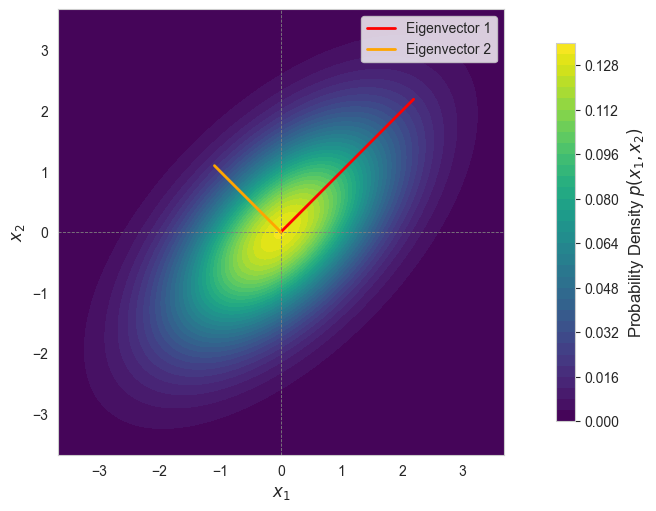

In [169]:
plot_surfaces_with_eigenvectors(x1, x2, pdf, mean, cov)

**Interpret:** Observe your plot. Do the lines you drew (representing the scaled eigenvectors) align perfectly with the ellipse's axes? Does the length of each line correspond to the spread (width/height) of the ellipse along that direction?

I think lines representing scaled eigenvectors align perfectly with the ellipse's axes. Lines length corresponds to the spread thanks to np.sqrt(eigvals[i]) and scaling